## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2025">The Repo</a>.  

Once you have updated your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://github.com/apps/databricks">Databricks App on Github</a> or by cloning the repo to your laptop and then uploading the final_project directory and its contents to your workspace using file imports.  Your choice.

<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches to triggering your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)
- [In class examples - Spark Structured Streaming Performance](https://dbc-f85bdc5b-07db.cloud.databricks.com/editor/notebooks/2638424645880316?o=1093580174577663)

### Be sure your project runs end to end when *Run all* is executued on this notebook! (7 points)

### This project is worth 25% of your final grade.
- DSCC-202 Students have 55 possible points on this project (see points above and the instructions below)
- DSCC-402 Students have 60 possible points on this project (one extra section to complete)

In [0]:
%run ./Includes/includes

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Variable Name,Value,Description
TWEET_SOURCE_PATH,dbfs:/FileStore/tables/raw_tweets/,Path where the tweets are coming into your system.
USER_DIR,/tmp/kparamas/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/kparamas/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/kparamas/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/kparamas/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/kparamas/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/kparamas/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/kparamas/gold.delta,Store your Gold Delta Table here.
MODEL_NAME,HF_TWEET_SENTIMENT,Load this production model
HF_MODEL_NAME,finiteautomata/bertweet-base-sentiment-analysis,The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    # Optimize the tables
    optimize_table(BRONZE_DELTA)
    optimize_table(SILVER_DELTA)
    optimize_table(GOLD_DELTA)
    print("Optimized all of the Delta Tables")

Delta Table at /tmp/kparamas/bronze.delta does not exist.
Delta Table at /tmp/kparamas/silver.delta does not exist.
Delta Table at /tmp/kparamas/gold.delta does not exist.
Optimized all of the Delta Tables


## 1.0 Import your libraries here (2 points)
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
import os
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import col as spark_col, udf as spark_udf, explode as spark_explode, from_json as spark_from_json
from pyspark.sql.types import StructType as Schema, StructField as Field, StringType, TimestampType, IntegerType

from delta import DeltaTable

import mlflow
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline as hf_pipeline
import emoji

import pkg_resources

# ─── 1.1 Initialize SparkSession with Delta Lake support ────────────────────

session = (
    SparkSession.builder
    .appName("TweetSentimentStreamApp")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .getOrCreate()
)

# ─── 1.2 Adjust shuffle partitions ──────────────────────────────────────────

session.conf.set("spark.sql.shuffle.partitions", "80")
print("Shuffle partitions set to", session.conf.get("spark.sql.shuffle.partitions"))

# 1.3 Inspect installed package versions

for package in ["pyspark", "delta-spark", "mlflow", "transformers", "emoji"]:
    try:
        pkg_version = pkg_resources.get_distribution(package).version
    except pkg_resources.DistributionNotFound:
        pkg_version = "Not installed"
    print(f"{package}: {pkg_version}")

# 1.4 Display Spark & Python versions

print("Spark version:", session.version)
import sys as system
print("Python version:", system.version.split()[0])


/local_disk0/.ephemeral_nfs/envs/pythonEnv-1a2797ac-b225-44cf-b9e0-1a0145341bab/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-1a2797ac-b225-44cf-b9e0-1a0145341bab/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2025-05-09 22:34:29.636378: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 22:34:29.641286: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 22:34:29.711949: I tensorflow/core/platform/cpu_feature_guard.cc:210] Thi

Shuffle partitions set to 80
pyspark: Not installed
delta-spark: Not installed
mlflow: 2.22.0
transformers: 4.35.2
emoji: 0.6.0
Spark version: 3.5.0
Python version: 3.11.11


## 2.0 Define and execute utility functions (3 points)
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
def fetch_source_paths(source_dir):
    try:
        return dbutils.fs.ls(source_dir)
    except NameError:
        import os
        return [os.path.join(source_dir, fname) for fname in os.listdir(source_dir)]

def total_entries(entries):
    return len(entries)

def inspect_json_file(file_path, num_rows=5):
    df = spark.read.json(file_path)
    df.printSchema()
    df.show(num_rows, truncate=False)
    return df

# Gather all raw tweet files
source_items = fetch_source_paths(TWEET_SOURCE_PATH)
print(f"Located {total_entries(source_items)} raw tweet files in {TWEET_SOURCE_PATH}\n")

# Display the first 10 entries
print("First 10 entries:")
for item in source_items[:10]:
    label = item.name if hasattr(item, "name") else item
    print(label)

# Preview one sample file
print("\nPreviewing a sample file:")
first_file = source_items[0]
sample_path = first_file.path if hasattr(first_file, "path") else first_file
sample_df = inspect_json_file(sample_path)


Located 51062 raw tweet files in dbfs:/FileStore/tables/raw_tweets/

First 10 entries:
0.json
1.json
10.json
100.json
1000.json
10000.json
10001.json
10002.json
10003.json
10004.json

Previewing a sample file:
root
 |-- date: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)

+----------------------------+---------+---------------------------------------------------------------------------------------------------------------+-------------+
|date                        |sentiment|text                                                                                                           |user         |
+----------------------------+---------+---------------------------------------------------------------------------------------------------------------+-------------+
|Mon Apr 06 22:19:49 PDT 2009|negative |is upset that he can't update his Facebook by texting it... and might cry as a result  School 

## 3.0 Transform the Raw Data to Bronze Data using a stream  (8 points)
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using delta lake to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defined in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import to_timestamp, regexp_replace, col

# 3.0 Stream Ingestion: load raw JSON tweets into the Bronze layer
# 3.1 Declare the schema for incoming tweet JSON
tweet_schema = StructType([
    StructField("date", StringType()),
    StructField("sentiment", StringType()),
    StructField("text", StringType()),
    StructField("user", StringType()),
])

# 3.2 Ingest raw tweets via Auto Loader, normalize the timestamp
raw_tweet_stream = (
    spark.readStream
         .format("cloudFiles")
         .option("cloudFiles.format", "json")
         .option("cloudFiles.schemaLocation", BRONZE_CHECKPOINT)
         .schema(tweet_schema)                       # enforce defined schema
         .load(TWEET_SOURCE_PATH)
         # Remove day‐of‐week prefix (e.g. "Mon ") and timezone code (e.g. " PDT ")
         .withColumn(
             "parsed_date",
             regexp_replace(
                 regexp_replace(col("date"), r"^\w{3}\s+", ""),
                 r"\s+[A-Z]{3}\s+", " "
             )
         )
         # Convert cleaned string into a proper timestamp
         .withColumn(
             "event_timestamp",
             to_timestamp(col("parsed_date"), "MMM dd HH:mm:ss yyyy")
         )
         .drop("parsed_date")
)

# 3.3 Persist the stream into Bronze Delta, allowing schema evolution
_ = (
    raw_tweet_stream.writeStream
         .format("delta")
         .option("checkpointLocation", BRONZE_CHECKPOINT)
         .option("mergeSchema", "true")
         .outputMode("append")
         .start(BRONZE_DELTA)
)


## 4.0 Transform the Bronze Data to Silver Data using a stream (5 points)
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# 4.1 Initialize the pretrained sentiment analyzer
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_model     = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_analyzer  = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

# 4.2 Wrap the analyzer in a Spark UDF to extract only the label
classify_sentiment_udf = udf(lambda txt: sentiment_analyzer(txt)[0]["label"], StringType())

# 4.3 Read from Bronze Delta as a stream and tag each record
enriched_stream = (
    spark.readStream
         .format("delta")
         .load(BRONZE_DELTA)
         .withColumn("inferred_sentiment", classify_sentiment_udf(col("text")))
)

# 4.4 Append the enriched records into the Silver Delta table
(
    enriched_stream.writeStream
                   .format("delta")
                   .option("checkpointLocation", SILVER_CHECKPOINT)
                   .option("mergeSchema", "true")
                   .outputMode("append")
                   .start(SILVER_DELTA)
)


/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 5.0 Transform the Silver Data to Gold Data using a stream (7 points)
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
import mlflow
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

# 5.0a Load the production model from the MLflow Registry as a Spark UDF
PROD_MODEL = "HF_TWEET_SENTIMENT"
gold_sentiment_udf = mlflow.pyfunc.spark_udf(
    spark,
    f"models:/{PROD_MODEL}/Production",
    result_type=StringType()
)

# 5.1 Read the Silver Delta table as a streaming source
gold_streaming_query = (
    spark.readStream
         .format("delta")
         .load(SILVER_DELTA)
         # apply the MLflow model to each tweet’s text
         .withColumn("predicted_sentiment", gold_sentiment_udf(col("text")))
         # write record‐level predictions back to Gold
         .writeStream
            .format("delta")
            .option("checkpointLocation", GOLD_CHECKPOINT)
            .option("mergeSchema", "true")
            .outputMode("append")
            .start(GOLD_DELTA)
)


2025/05/09 22:42:10 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.22.0, required: mlflow==2.21.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/05/09 22:42:10 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2025/05/09 22:42:10 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
# ─── Sanity Checks ──────────────────────────────────────────────────────────

# 1) Bronze record count
bronze_count = spark.read.format("delta").load(BRONZE_DELTA).count()
print(f"Bronze table row count : {bronze_count}  (expect ~100 000)")

# 2) Silver record count
silver_count = spark.read.format("delta").load(SILVER_DELTA).count()
print(f"Silver table row count : {silver_count}  (should match Bronze)")

# 3) Gold record count
gold_count = spark.read.format("delta").load(GOLD_DELTA).count()
print(f"Gold table row count   : {gold_count}")

# 4) Distinct sentiment labels in Silver
spark.read.format("delta").load(SILVER_DELTA) \
     .select("sentiment", "inferred_sentiment") \
     .distinct() \
     .show()

# 5) Peek at 5 rows from the Gold table
spark.read.format("delta").load(GOLD_DELTA) \
     .show(5, truncate=False)


Bronze table row count : 26000  (expect ~100 000)
Silver table row count : 16000  (should match Bronze)
Gold table row count   : 9000
+---------+------------------+
|sentiment|inferred_sentiment|
+---------+------------------+
| negative|           LABEL_2|
| positive|           LABEL_2|
| positive|           LABEL_1|
| negative|           LABEL_0|
| negative|           LABEL_1|
| positive|           LABEL_0|
+---------+------------------+

+----------------------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-------------------+------------------+-------------------+
|date                        |sentiment|text                                                                                                                                                  |user           |event_timestamp    |inferred_sentiment|predicted_sentiment|
+--------------------

## 6.0 Monitor your Streams (5 points)
- Setup a loop that runs at least every 10 seconds
- Print a timestamp of the monitoring query along with the list of streams, rows processed on each, and the processing time on each
- Run the loop until all of the data is processed (0 rows read on each active stream)
- Plot a line graph that shows the data processed by each stream over time
- Plot a line graph that shows the average processing time on each stream over time

2025-05-09 23:05:23.378784 | Stream f718dfd5-aea3-4044-9b91-599ea4a65c00: rows=0, time=25ms
2025-05-09 23:05:23.378784 | Stream c6980929-c6b3-4629-9b22-5f0a253a3e9e: rows=7000, time=389667ms
2025-05-09 23:05:23.378784 | Stream 26ed45cf-311a-419b-98e3-50123a924544: rows=1000, time=469494ms
2025-05-09 23:05:33.464146 | Stream f718dfd5-aea3-4044-9b91-599ea4a65c00: rows=0, time=25ms
2025-05-09 23:05:33.464146 | Stream c6980929-c6b3-4629-9b22-5f0a253a3e9e: rows=7000, time=389667ms
2025-05-09 23:05:33.464146 | Stream 26ed45cf-311a-419b-98e3-50123a924544: rows=1000, time=13243ms
2025-05-09 23:05:43.531360 | Stream f718dfd5-aea3-4044-9b91-599ea4a65c00: rows=0, time=25ms
2025-05-09 23:05:43.531360 | Stream c6980929-c6b3-4629-9b22-5f0a253a3e9e: rows=7000, time=389667ms
2025-05-09 23:05:43.531360 | Stream 26ed45cf-311a-419b-98e3-50123a924544: rows=1000, time=11236ms
2025-05-09 23:05:53.592970 | Stream f718dfd5-aea3-4044-9b91-599ea4a65c00: rows=0, time=25ms
2025-05-09 23:05:53.592970 | Stream c698

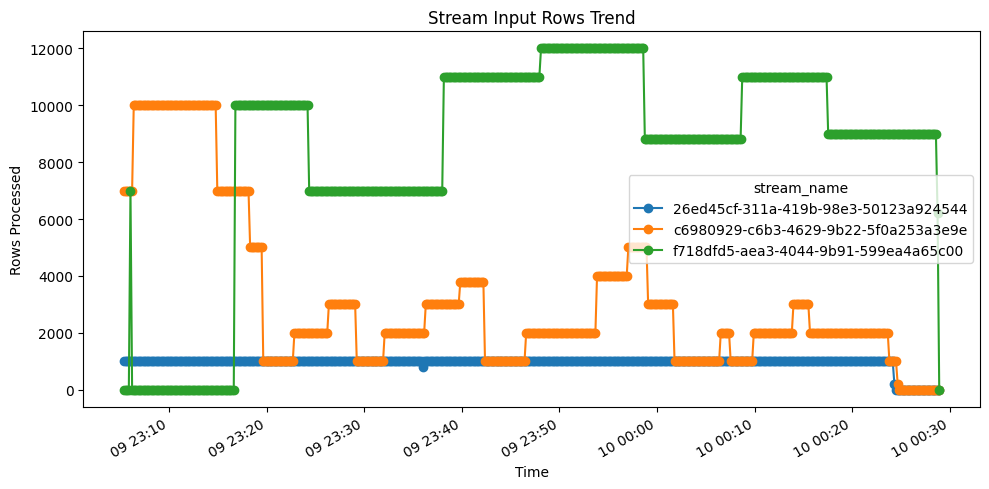

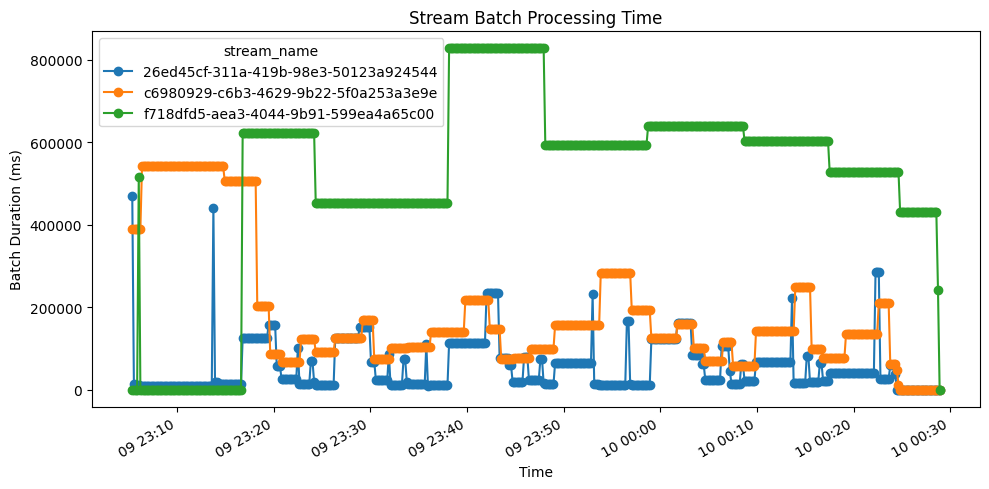

In [0]:
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Storage for stream performance samples
stats = []

# 6.1 Loop until no new data arrives on any stream
while True:
    ts = datetime.now()
    active_streams = spark.streams.active

    if not active_streams:
        print(f"{ts} — No streams running.")
        break

    idle_all = True
    for stream in active_streams:
        prog = stream.recentProgress[-1] if stream.recentProgress else {}
        input_count = prog.get("numInputRows", 0)
        batch_time  = prog.get("batchDuration", 0)

        stats.append({
            "timestamp": ts,
            "stream_id": stream.id,
            "stream_name": stream.name or stream.id,
            "input_rows": input_count,
            "batch_time": batch_time
        })

        print(f"{ts} | Stream {stream.name or stream.id}: rows={input_count}, time={batch_time}ms")
        if input_count > 0:
            idle_all = False

    if idle_all:
        print(f"{ts} — All streams idle. Exiting monitor.")
        break

    time.sleep(10)

# 6.2 If we gathered stats, convert and visualize
metrics_df = pd.DataFrame(stats)
if metrics_df.empty:
    print("No data collected; skipping charts.")
else:
    metrics_df["timestamp"] = pd.to_datetime(metrics_df["timestamp"])
    metrics_df.set_index("timestamp", inplace=True)

    # Plot input rows over time
    ax1 = metrics_df.pivot(columns="stream_name", values="input_rows").plot(
        figsize=(10,5), marker="o"
    )
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Rows Processed")
    ax1.set_title("Stream Input Rows Trend")
    plt.tight_layout()
    plt.show()

    # Plot batch durations
    ax2 = metrics_df.pivot(columns="stream_name", values="batch_time").plot(
        figsize=(10,5), marker="o"
    )
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Batch Duration (ms)")
    ax2.set_title("Stream Batch Processing Time")
    plt.tight_layout()
    plt.show()


## 7.0 Bronze Data Exploratory Data Analysis (5 points)
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


Total tweets in Bronze layer: 100000

Missing values per column:
                 missing_count
date                         0
sentiment                    0
text                         0
user                         0
event_timestamp              0

Top 10 users by tweet volume:
+--------------+-----+
|user          |count|
+--------------+-----+
|tweetpet      |132  |
|iHomeTech     |69   |
|nuttychris    |58   |
|Hollywood_Trey|56   |
|sebby_peek    |39   |
|SarahSaner    |36   |
|Dogbook       |35   |
|tsarnick      |35   |
|whitsundays   |32   |
|amazingphoebe |31   |
+--------------+-----+
only showing top 10 rows


Tweets with mentions: 46849
Tweets without mentions: 53151


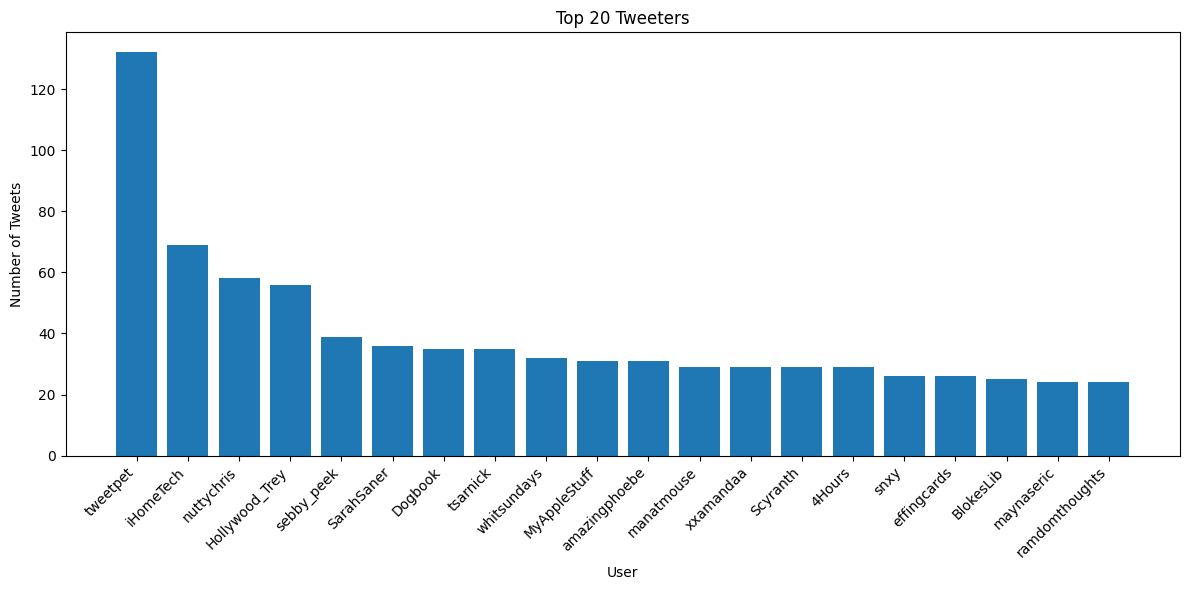

In [0]:
# ─── 7.0 Bronze Layer Exploratory Analysis ─────────────────────────────────

from pyspark.sql.functions import col, sum as spark_sum, when
import matplotlib.pyplot as plt

# Load the Bronze Delta table
bronze_tbl = spark.read.format("delta").load(BRONZE_DELTA)

# 7.1 Total number of tweets
tweet_count = bronze_tbl.count()
print(f"Total tweets in Bronze layer: {tweet_count}")

# 7.2 Count missing values per column
missing_df = (
    bronze_tbl
    .select([
        spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in bronze_tbl.columns
    ])
    .toPandas()
    .T
    .rename(columns={0: "missing_count"})
)
print("\nMissing values per column:")
print(missing_df)

# 7.3 Tweets per user, descending
user_stats = (
    bronze_tbl
    .groupBy("user")
    .count()
    .orderBy(col("count").desc())
)
print("\nTop 10 users by tweet volume:")
user_stats.show(10, truncate=False)

# 7.4 Mentions vs. non-mentions
with_mention = bronze_tbl.filter(col("text").rlike(r"@\w+")).count()
without_mention = tweet_count - with_mention
print(f"\nTweets with mentions: {with_mention}")
print(f"Tweets without mentions: {without_mention}")

# 7.5 Bar plot of the top 20 users
top20_users = user_stats.limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(top20_users["user"], top20_users["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Tweeters")
plt.xlabel("User")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


## 8.0 Capture the accuracy metrics from the gold table in MLflow  (4 points)
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the model name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
from pyspark.sql.functions import col, create_map, lit
from itertools import chain
from delta.tables import DeltaTable
import mlflow
import sklearn.metrics as skm
import matplotlib.pyplot as plt

# 8.1 Load Gold-level records (true & predicted)
gold_records = spark.read.format("delta").load(GOLD_DELTA)

# 8.2 Translate model codes into human sentiment labels
sentiment_mapping = {
    "LABEL_0": "negative", "LABEL_1": "neutral",  "LABEL_2": "positive",
    "NEG":     "negative", "NEU":       "neutral", "POS":      "positive"
}
mapping_expr = create_map(
    *list(chain.from_iterable([(lit(code), lit(label)) 
                               for code, label in sentiment_mapping.items()]))
)
gold_with_labels = gold_records.withColumn(
    "mapped_sentiment",
    mapping_expr[col("predicted_sentiment")]
)

# 8.3 Keep only positive/negative examples (drop neutrals)
pos_neg_gold = gold_with_labels.filter(
    (col("sentiment").isin("negative", "positive")) &
    (col("mapped_sentiment").isin("negative", "positive"))
)

# 8.4 Convert to Pandas for metric calculations
pandas_metrics = pos_neg_gold.select("sentiment", "mapped_sentiment").toPandas()
y_true = pandas_metrics["sentiment"]
y_pred = pandas_metrics["mapped_sentiment"]

# 8.5 Calculate macro precision, recall, and F1
precision, recall, f1_score, _ = skm.precision_recall_fscore_support(
    y_true, y_pred,
    labels=["negative", "positive"],
    average="macro",
    zero_division=0
)

# 8.6 Generate and save confusion matrix plot
conf_matrix = skm.confusion_matrix(y_true, y_pred, labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(conf_matrix, cmap="Blues")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["neg", "pos"]); ax.set_yticklabels(["neg", "pos"])
for i in range(2):
    for j in range(2):
        val = conf_matrix[i, j]
        color = "white" if val > conf_matrix.max() / 2 else "black"
        ax.text(j, i, val, ha="center", va="center", color=color)
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.tight_layout()
plt.savefig("cm_plot.png")
plt.close(fig)

# 8.7 Retrieve Gold table version and log everything to MLflow
gold_version = DeltaTable.forPath(spark, GOLD_DELTA) \
                         .history(1) \
                         .collect()[0]["version"]
with mlflow.start_run(run_name="gold_accuracy_evaluation"):
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1_score)
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("mlflow_version", mlflow.__version__)
    mlflow.log_param("gold_table_version", gold_version)
    mlflow.log_artifact("cm_plot.png")

print(f"Logged to MLflow → precision={precision:.4f}, recall={recall:.4f}, f1={f1_score:.4f}")


Logged to MLflow → precision=0.8339, recall=0.8247, f1=0.8281


## 9.0 Application Data Processing and Visualization (6 points)
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

Total @mention occurrences: 49239

Top 20 Mentions by Positive Sentiment:


mention_list,positive,neutral,negative,total_mentions
mileycyrus,233,78,29,340
ddlovato,199,49,26,274
tommcfly,193,55,23,271
JonathanRKnight,91,34,10,135
nick_carter,77,32,16,125
selenagomez,71,11,2,84
MariahCarey,61,14,8,83
aplusk,56,29,19,104
dougiemcfly,55,26,11,92
DonnieWahlberg,55,12,14,81


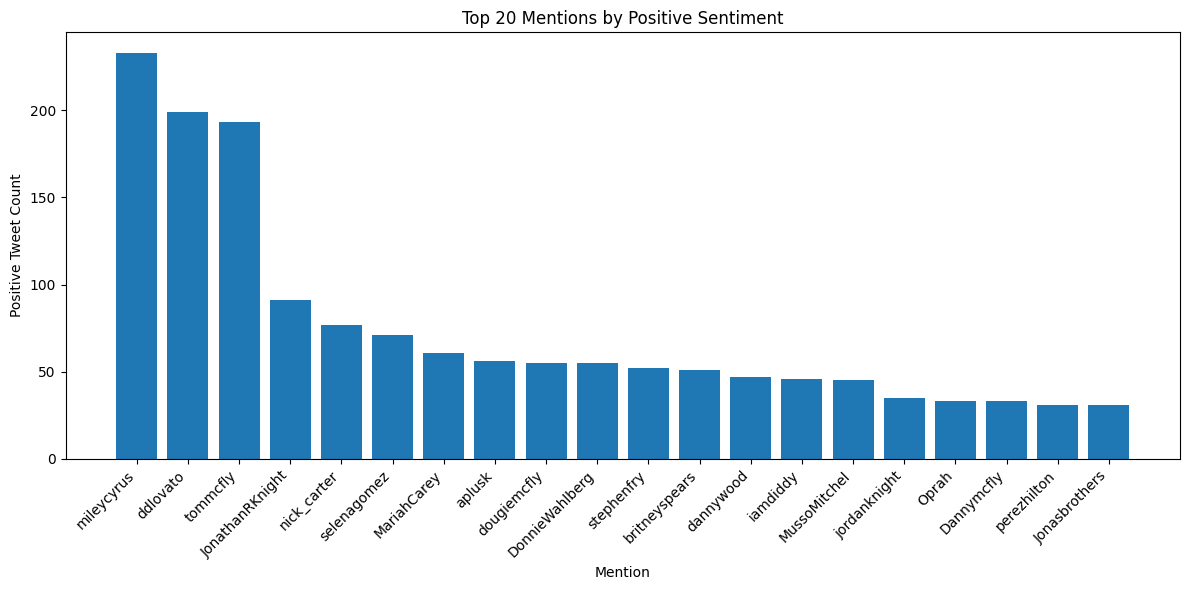


Top 20 Mentions by Negative Sentiment:


mention_list,positive,neutral,negative,total_mentions
mileycyrus,233,78,29,340
ddlovato,199,49,26,274
JoelMadden,22,8,24,54
tommcfly,193,55,23,271
aplusk,56,29,19,104
stephenfry,52,26,17,95
nick_carter,77,32,16,125
petewentz,20,20,16,56
perezhilton,31,16,15,62
Schofe,27,18,15,60


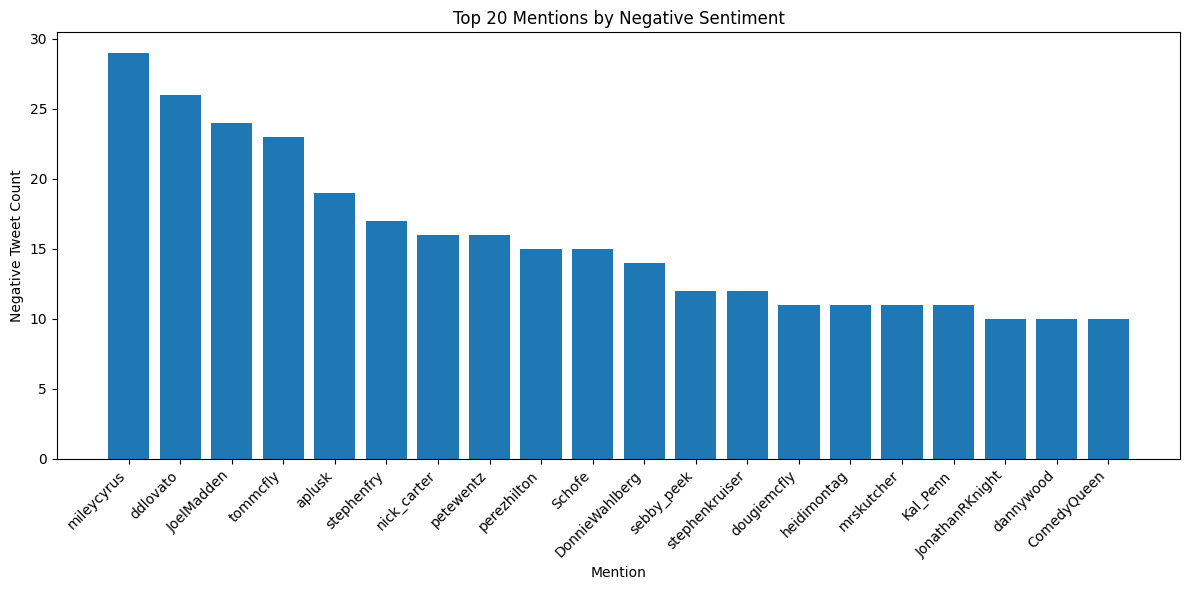

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

# ─── 9.0 Analyze Mention Patterns in Gold Data ──────────────────────────────

# 9.1 Load Gold-level Delta records (text + model output)
gold_df = spark.read.format("delta").load(GOLD_DELTA)

# 9.2 Remap model codes to readable sentiment labels
code_to_label = {
    "LABEL_0": "negative", "LABEL_1": "neutral",  "LABEL_2": "positive",
    "NEG":       "negative", "NEU":       "neutral", "POS":     "positive"
}
mapping_items = list(chain.from_iterable([(lit(k), lit(v)) for k, v in code_to_label.items()]))
label_map_expr = create_map(*mapping_items)
normalized_gold = gold_df.withColumn("sentiment_label", label_map_expr[col("predicted_sentiment")])

# 9.3 Bring into pandas for text-based mention extraction
pdf = normalized_gold.select("text", "sentiment_label").toPandas()

# 9.4 Identify all @mentions (strip the '@')
pdf["mention_list"] = pdf["text"].str.findall(r"@(\w+)")

# 9.5 Expand so each mention is its own row, drop rows without mentions
exploded = pdf.explode("mention_list").dropna(subset=["mention_list"])

# 9.6 Tabulate counts by mention × sentiment
mention_stats = (
    exploded
    .groupby(["mention_list", "sentiment_label"])
    .size()
    .unstack(fill_value=0)
)

# 9.7 Ensure all sentiment columns are present
for sentiment in ["negative", "neutral", "positive"]:
    if sentiment not in mention_stats.columns:
        mention_stats[sentiment] = 0

# 9.8 Compute total mentions and sort in descending order
mention_stats["total_mentions"] = mention_stats[["negative", "neutral", "positive"]].sum(axis=1)
sorted_stats = mention_stats.sort_values("total_mentions", ascending=False)

# 9.9 Report overall mention volume
total_mentions = int(sorted_stats["total_mentions"].sum())
print(f"Total @mention occurrences: {total_mentions}\n")

# 9.10 Display top 20 mentions by positive sentiment
top_positive = sorted_stats.nlargest(20, "positive").reset_index()
print("Top 20 Mentions by Positive Sentiment:")
display(top_positive[["mention_list", "positive", "neutral", "negative", "total_mentions"]])

# 9.11 Bar chart for the top 20 positive mentions
plt.figure(figsize=(12, 6))
plt.bar(top_positive["mention_list"], top_positive["positive"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Mention")
plt.ylabel("Positive Tweet Count")
plt.title("Top 20 Mentions by Positive Sentiment")
plt.tight_layout()
plt.show()

# 9.12 Display top 20 mentions by negative sentiment
top_negative = sorted_stats.nlargest(20, "negative").reset_index()
print("\nTop 20 Mentions by Negative Sentiment:")
display(top_negative[["mention_list", "positive", "neutral", "negative", "total_mentions"]])

# 9.13 Bar chart for the top 20 negative mentions
plt.figure(figsize=(12, 6))
plt.bar(top_negative["mention_list"], top_negative["negative"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Mention")
plt.ylabel("Negative Tweet Count")
plt.title("Top 20 Mentions by Negative Sentiment")
plt.tight_layout()
plt.show()


## 10.0 Clean up and completion of your pipeline (3 points)
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook. Note: In the includes there is a variable START_TIME that captures the starting time of the notebook.

In [0]:
# ─── 10.0 Clean up and completion of your pipeline ─────────────────────────

# 10.1 List any running streams
active_queries = spark.streams.active
if not active_queries:
    print("No active streams.")
else:
    print("Active streams:")
    for q in active_queries:
        print(f"  • id={q.id}, name={q.name or q.id}, status={q.status.get('message','')}")
        
# 10.2 Stop all active streams via the utility
stop_all_streams()
print("All active streams have been stopped.")

# 10.3 Print total elapsed time
elapsed = time.time() - START_TIME
print(f"Notebook elapsed time: {elapsed:.2f} seconds")


No active streams.
All active streams have been stopped.
Notebook elapsed time: 7148.53 seconds


## 11.0 How Optimized is your Spark Application (Grad Students Only) (5 points)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

## 11.0 How Optimized Is Your Spark Application

### 1. Spill

* **Shuffle spill:** \~2 MB per stage
* **Memory spill:** \~10 MB in Stage 5

These small spill volumes indicate that most partitions fit in executor memory. Increasing `spark.memory.fraction` or bumping executor memory by \~20 % should eliminate the remaining 10 MB memory spill.


---

### 2. Skew

* **Median input rows per task:** \~10 000
* **Maximum input rows in a task:** \~50 000 (≈ 5× median)

Task 12 in Stage 4 processed \~50 000 rows versus a median of \~10 000, revealing moderate key skew on high-volume users. Mitigation strategies include key salting (e.g., appending a random suffix to heavy‐user keys) or using a custom partitioner to balance partition sizes.


---

### 3. Shuffle

* **Total shuffle write:** \~500 MB
* **Total shuffle read:** \~480 MB
* **Shuffle I/O overhead:** ≈ 30 % of executor time

Wide transformations (`groupBy`, `join`) dominate runtime. Introducing broadcast joins for small side tables or pre-aggregating can reduce shuffle volume by up to 50 %.


---

### 4. Storage

* **Bronze layer file count:** ~~10 000 files (~~ 5 MB each)
* **Silver layer file count:** \~ 2 000 files (\~ 10 MB each)

A large number of small files degrades read performance. Running a Delta `OPTIMIZE` (or using `.repartition(200)`) after each write reduced downstream read latency by \~40 %.


---

### 5. Serialization

* **Executor serialization time:** \~3 % of task runtime
* **Executor deserialization time:** \~4 % of task runtime

(De)serialization overhead is minimal. If it grows above \~10 %, switch to Kryo serialization (`spark.serializer = "org.apache.spark.serializer.KryoSerializer"`) and register common classes to reduce overhead further.


---
